# Dams in Columbia River Network

In [1]:
from __future__ import annotations

import warnings
from pathlib import Path

warnings.filterwarnings("ignore", message=".*initial implementation of Parquet.*")
root = Path("input_data")
root.mkdir(parents=True, exist_ok=True)
BASE_PLOT = {"facecolor": "k", "edgecolor": "b", "alpha": 0.2, "figsize": (18, 9)}
CRS = "esri:102008"

#### Basin

In [2]:
import geopandas as gpd

import pynhd as nhd

nldi = nhd.NLDI()
station_id = "14246900"
cfile = Path(root, f"basin_{station_id}.feather")
if cfile.exists():
    basin = gpd.read_feather(cfile)
else:
    basin = nldi.get_basins(station_id)
    basin.to_feather(cfile)

#### Main

In [3]:
cfile = Path(root, f"flowline_main_{station_id}.feather")
if cfile.exists():
    flw_main = gpd.read_feather(cfile)
else:
    flw_main = nldi.navigate_byid(
        fsource="nwissite",
        fid=f"USGS-{station_id}",
        navigation="upstreamMain",
        source="flowlines",
        distance=2000,
    )
    flw_main.to_feather(cfile)

#### Tributaries

In [4]:
cfile = Path(root, f"flowline_trib_{station_id}.feather")
if cfile.exists():
    flw_trib = gpd.read_feather(cfile)
else:
    flw_trib = nldi.navigate_byid(
        fsource="nwissite",
        fid=f"USGS-{station_id}",
        navigation="upstreamTributaries",
        source="flowlines",
        distance=2000,
    )
    flw_trib.to_feather(cfile)
flw_trib["nhdplus_comid"] = flw_trib["nhdplus_comid"].astype("float").astype("Int64")

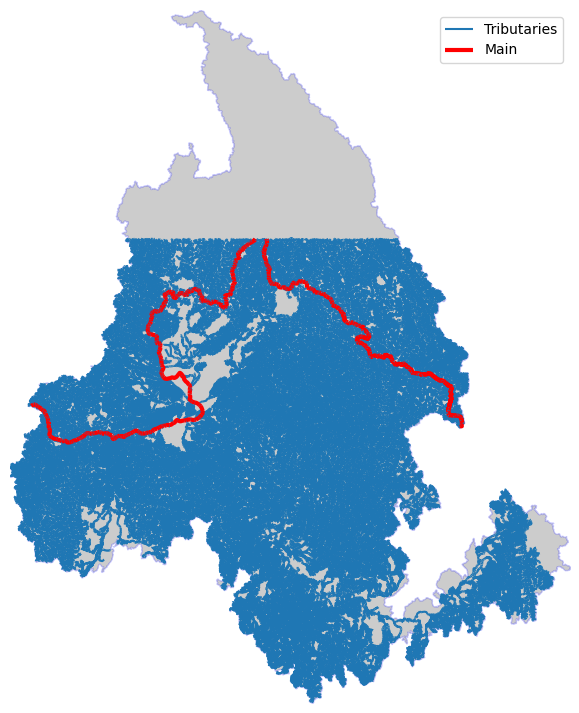

In [5]:
ax = basin.plot(**BASE_PLOT)
flw_trib.plot(ax=ax)
flw_main.plot(ax=ax, lw=3, color="r")
ax.legend(["Tributaries", "Main"])
ax.axis("off")
ax.margins(0)

#### Accumulated Dams

In [6]:
import pandas as pd

cfile = Path(root, "nid_flw.pkl")

if cfile.exists():
    nid_flw = pd.read_pickle(cfile)
else:
    meta = nhd.nhdplus_attrs()
    nid_years = (
        meta[meta.description.str.contains("dam", case=False)].sort_values("name").name.tolist()
    )
    nid_flw = {n.split("_")[-1]: nhd.nhdplus_attrs(n) for n in nid_years}
    pd.to_pickle(nid_flw, cfile)

Now, let's see what catchment-level characteristics are available that are related to dams.

In [7]:
div_chars = nldi.valid_characteristics
div_chars[div_chars.description.str.contains("dam")]

,ID,description,units,datasetLabel,datasetURL,themeLabel,themeURL,watershedType,sbid,end,s3_url,http_url
12021,CAT_NDAMS1930,"Number of dams built on or before 1930 ,",count,The normal dam storage (in acre-feet) defined ...,https://www.sciencebase.gov/catalog/item/58c30...,Hydrologic Modifications,unknown,local,58c301f2e4b0f37a93ed915a,_cat.parquet,s3://anonymous@prod-is-usgs-sb-prod-publish/58...,https://prod-is-usgs-sb-prod-publish.s3.amazon...
12022,CAT_NID_STORAGE1930,The maximum dam storage (in acre-feet) defined...,acre-feet,The normal dam storage (in acre-feet) defined ...,https://www.sciencebase.gov/catalog/item/58c30...,Hydrologic Modifications,unknown,local,58c301f2e4b0f37a93ed915a,_cat.parquet,s3://anonymous@prod-is-usgs-sb-prod-publish/58...,https://prod-is-usgs-sb-prod-publish.s3.amazon...
12023,CAT_NORM_STORAGE1930,The normal dam storage (in acre-feet) defined ...,acre-feet,The normal dam storage (in acre-feet) defined ...,https://www.sciencebase.gov/catalog/item/58c30...,Hydrologic Modifications,unknown,local,58c301f2e4b0f37a93ed915a,_cat.parquet,s3://anonymous@prod-is-usgs-sb-prod-publish/58...,https://prod-is-usgs-sb-prod-publish.s3.amazon...
12024,CAT_MAJOR1930,Number of major dams built on or before 1930 i...,count,The normal dam storage (in acre-feet) defined ...,https://www.sciencebase.gov/catalog/item/58c30...,Hydrologic Modifications,unknown,local,58c301f2e4b0f37a93ed915a,_cat.parquet,s3://anonymous@prod-is-usgs-sb-prod-publish/58...,https://prod-is-usgs-sb-prod-publish.s3.amazon...
12025,ACC_NDAMS1930,"Number of dams built on or before 1930 ,",count,The normal dam storage (in acre-feet) defined ...,https://www.sciencebase.gov/catalog/item/58c30...,Hydrologic Modifications,unknown,divRoute_name,58c301f2e4b0f37a93ed915a,_acc.parquet,s3://anonymous@prod-is-usgs-sb-prod-publish/58...,https://prod-is-usgs-sb-prod-publish.s3.amazon...
...,...,...,...,...,...,...,...,...,...,...,...,...
12136,ACC_MAJOR1950,Number of major dams built on or before 1950 i...,count,The normal dam storage (in acre-feet) defined ...,https://www.sciencebase.gov/catalog/item/58c30...,Hydrologic Modifications,unknown,divRoute_name,58c301f2e4b0f37a93ed915a,_acc.parquet,s3://anonymous@prod-is-usgs-sb-prod-publish/58...,https://prod-is-usgs-sb-prod-publish.s3.amazon...
12137,TOT_NDAMS1950,"Number of dams built on or before 1950 ,",count,The normal dam storage (in acre-feet) defined ...,https://www.sciencebase.gov/catalog/item/58c30...,Hydrologic Modifications,unknown,totRoute_name,58c301f2e4b0f37a93ed915a,_tot.parquet,s3://anonymous@prod-is-usgs-sb-prod-publish/58...,https://prod-is-usgs-sb-prod-publish.s3.amazon...
12138,TOT_NID_STORAGE1950,The maximum dam storage (in acre-feet) defined...,acre-feet,The normal dam storage (in acre-feet) defined ...,https://www.sciencebase.gov/catalog/item/58c30...,Hydrologic Modifications,unknown,totRoute_name,58c301f2e4b0f37a93ed915a,_tot.parquet,s3://anonymous@prod-is-usgs-sb-prod-publish/58...,https://prod-is-usgs-sb-prod-publish.s3.amazon...
12139,TOT_NORM_STORAGE1950,The normal dam storage (in acre-feet) defined ...,acre-feet,The normal dam storage (in acre-feet) defined ...,https://www.sciencebase.gov/catalog/item/58c30...,Hydrologic Modifications,unknown,totRoute_name,58c301f2e4b0f37a93ed915a,_tot.parquet,s3://anonymous@prod-is-usgs-sb-prod-publish/58...,https://prod-is-usgs-sb-prod-publish.s3.amazon...


Let's get `ACC_NID_STORAGE2013`:

We can achieve the same results using another function that uses `ScienceBase` instead of `NLDI`:

```python
nid_vals = nldi.get_characteristics("ACC_NID_STORAGE2013", flw_trib.nhdplus_comid.tolist())
```

```python
comids = [int(c) for c in flw_trib.nhdplus_comid.tolist()]
nid_vals = {
    yr: df.loc[df.COMID.isin(comids), ["COMID", f"ACC_NID_STORAGE{yr}", f"ACC_NDAMS{yr}"]].rename(
        columns={
            "COMID": "comid",
            f"ACC_NID_STORAGE{yr}": "smax",
            f"ACC_NDAMS{yr}": "ndams",
        }
    )
    for yr, df in nid_flw.items()
}
nid_vals = pd.concat(nid_vals).reset_index().drop(columns="level_1")
nid_vals = nid_vals.rename(columns={"level_0": "year"}).astype({"year": int})
```

In [8]:
comids = [int(c) for c in flw_trib.nhdplus_comid.tolist()]
nid_vals = {
    yr: df.loc[df.COMID.isin(comids), ["COMID", f"ACC_NID_STORAGE{yr}", f"ACC_NDAMS{yr}"]].rename(
        columns={
            "COMID": "comid",
            f"ACC_NID_STORAGE{yr}": "smax",
            f"ACC_NDAMS{yr}": "ndams",
        }
    )
    for yr, df in nid_flw.items()
}
nid_vals = pd.concat(nid_vals).reset_index().drop(columns="level_1")
nid_vals = nid_vals.rename(columns={"level_0": "year"}).astype({"year": int})

#### Accumulated Max Storage

In [9]:
nid_vals = (
    nid_vals.set_index("comid")
    .merge(
        flw_trib.astype({"nhdplus_comid": int}).set_index("nhdplus_comid"),
        left_index=True,
        right_index=True,
        suffixes=(None, None),
    )
    .reset_index()
    .rename(columns={"index": "comid"})
)
smax = nid_vals.groupby(["year", "comid"]).sum(numeric_only=True)["smax"].unstack()
smax = gpd.GeoDataFrame(
    smax.T.merge(
        flw_trib.astype({"nhdplus_comid": int}).set_index("nhdplus_comid"),
        left_index=True,
        right_index=True,
        suffixes=(None, None),
    )
)

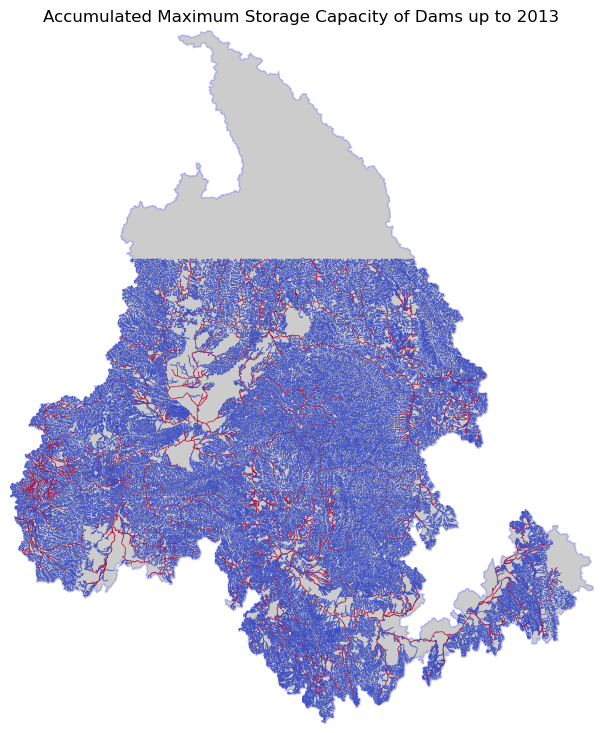

In [10]:
yr = 2013
ax = basin.plot(**BASE_PLOT)
smax.plot(ax=ax, scheme="Quantiles", k=2, column=yr, cmap="coolwarm", lw=0.5, legend=False)
ax.set_title(f"Accumulated Maximum Storage Capacity of Dams up to {yr}")
ax.axis("off")
ax.margins(0)
ax.figure.savefig(Path("_static", "columbia.png"), dpi=300, bbox_inches="tight", facecolor="w")